In [1]:
!nvidia-smi

Tue Apr  5 07:45:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam

## CNN

In [4]:
# batch 的大小，如果出現 OOM error，請降低這個值
batch_size = 128
# 類別的數量，Cifar 10 共有 10 個類別
num_classes = 10
# 訓練的 epochs 數量
epochs = 10

# 讀取資料並檢視
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# 對 label 進行 one-hot encoding (y_trian 原本是純數字)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# 將資料變為 float32 並標準化
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

170508288/170498071 [==============================] - 4s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [5]:
input_layer = keras.layers.Input(x_train.shape[1:])

x = Conv2D(32, (3, 3), padding='same')(input_layer)
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.2)(x)

x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.2)(x)

x = Flatten()(x)

x = Dense(units=512)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)

out = Dense(units=num_classes, activation="softmax")(x)

model = keras.models.Model(inputs=[input_layer], outputs=[out])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                             

In [6]:
def cifar_generator(x, y, batch_size):
    while True:
        for indexs in range(0, len(x), batch_size):
            images = x[indexs: indexs+batch_size]
            labels = y[indexs: indexs+batch_size]
            yield images, labels

In [7]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

history_cnn = model.fit(cifar_generator(x_train, y_train, batch_size),
                        steps_per_epoch=int(len(x_train)/batch_size),
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print("====================")
print(f'Test loss: {score[0]:.4f}')
print(f'Test accuracy: {score[1]:.4f}')
print("====================")

Epoch 1/10
390/390 [==============================] - 15s 14ms/step - loss: 1.4039 - accuracy: 0.5141 - val_loss: 2.2154 - val_accuracy: 0.3260
Epoch 2/10
390/390 [==============================] - 5s 14ms/step - loss: 0.9458 - accuracy: 0.6642 - val_loss: 1.0431 - val_accuracy: 0.6278
Epoch 3/10
390/390 [==============================] - 5s 14ms/step - loss: 0.7930 - accuracy: 0.7212 - val_loss: 1.0674 - val_accuracy: 0.6389
Epoch 4/10
390/390 [==============================] - 5s 14ms/step - loss: 0.6997 - accuracy: 0.7531 - val_loss: 0.8602 - val_accuracy: 0.6992
Epoch 5/10
390/390 [==============================] - 5s 13ms/step - loss: 0.6314 - accuracy: 0.7765 - val_loss: 0.8900 - val_accuracy: 0.7087
Epoch 6/10
390/390 [==============================] - 5s 13ms/step - loss: 0.5759 - accuracy: 0.7975 - val_loss: 0.6488 - val_accuracy: 0.7780
Epoch 7/10
390/390 [==============================] - 5s 14ms/step - loss: 0.5219 - accuracy: 0.8154 - val_loss: 0.6314 - val_accuracy: 0.783

## Plot

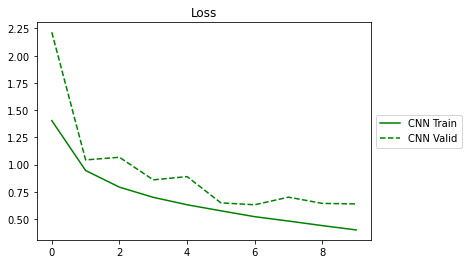

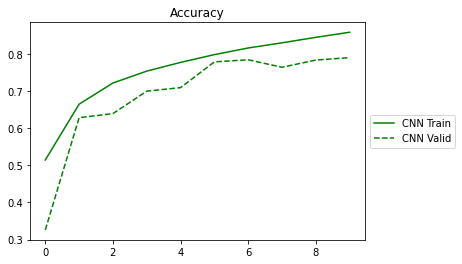

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()

plt.plot(range(len(history_cnn.history['loss'])), 
         history_cnn.history['loss'], 
         '-', label="CNN Train", color="g")

plt.plot(range(len(history_cnn.history['val_loss'])),
         history_cnn.history['val_loss'], 
         '--', label="CNN Valid", color="g")

plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure()

plt.plot(range(len(history_cnn.history['accuracy'])), 
         history_cnn.history['accuracy'], 
         '-', label="CNN Train", color="g")

plt.plot(range(len(history_cnn.history['val_accuracy'])),
         history_cnn.history['val_accuracy'], 
         '--', label="CNN Valid", color="g")
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()